Covid-19 Machine Learning Model

This ML project aims to predict what patients should be a priority in receiving ICU care based on data collected from Hospital Sírio-Libanês, São Paulo and Brasilia

In [35]:
#Importing libraries
     #Libraries used for data manipulation, analysis, and visualization
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tabulate import tabulate # Used for formatting the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split # Used for splitting the data into training and testing set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings('ignore')   # Suppress all warnings

In [4]:
#Display first 10 rows of dataframe
df_orig = pd.read_excel(r'C:\Capstone\Kaggle_Sirio_Libanes_ICU_Prediction.xlsx') 
print(tabulate(df_orig.head(10), headers=df_orig.columns, tablefmt="fancy_grid"))


╒════╤════════════════════════════╤═══════════════╤═════════════════╤══════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═══════╤═════════════════════╤═════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤══════════════════════╤════════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤════════════════╤══════════════╤═════════════╤═════════════╤══════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════

# Exploratory Data Analysis


Exploratory Data Analysis

In [5]:
#Column Names and Data Types
print("Number of Rows and Columns:", df_orig.shape)
columns_info = pd.DataFrame({
    'Column Name': df_orig.columns,
    'Data Type': [df_orig[col].dtype for col in df_orig.columns]
})
                            
print(tabulate(columns_info, headers='keys', tablefmt='fancy_grid'))

Number of Rows and Columns: (1925, 231)
╒═════╤══════════════════════════════════╤═════════════╕
│     │ Column Name                      │ Data Type   │
╞═════╪══════════════════════════════════╪═════════════╡
│   0 │ PATIENT_VISIT_IDENTIFIER         │ int64       │
├─────┼──────────────────────────────────┼─────────────┤
│   1 │ AGE_ABOVE65                      │ int64       │
├─────┼──────────────────────────────────┼─────────────┤
│   2 │ AGE_PERCENTIL                    │ object      │
├─────┼──────────────────────────────────┼─────────────┤
│   3 │ GENDER                           │ int64       │
├─────┼──────────────────────────────────┼─────────────┤
│   4 │ DISEASE GROUPING 1               │ float64     │
├─────┼──────────────────────────────────┼─────────────┤
│   5 │ DISEASE GROUPING 2               │ float64     │
├─────┼──────────────────────────────────┼─────────────┤
│   6 │ DISEASE GROUPING 3               │ float64     │
├─────┼──────────────────────────────────┼──────

In [6]:
#Covid-ICU Data Summary Statistics
df_update_summary = df_orig.describe()
print(tabulate(df_update_summary, headers='keys', tablefmt='fancy_grid'))

╒═══════╤════════════════════════════╤═══════════════╤═════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═════════════╤═════════════════════╤═════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤══════════════════════╤════════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤════════════════╤══════════════╤═════════════╤═════════════╤══════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤══════

Cleansing + Pre-processing

In [7]:
#Handling Missing Data Entries
missing_values = df_orig.isnull().sum()
missing_values = pd.DataFrame({
    'Column Name': missing_values.index,
    'Number Missing Entries': missing_values.values
})
#Displaying number of missing entries for each column
print("Number of Missing Entries:")
print(tabulate(missing_values, headers='keys', tablefmt='fancy_grid'))

#Filling missing entries
    #As per the data source, missing values can be replaced by previous entries
df_fill_values = df_orig.groupby('PATIENT_VISIT_IDENTIFIER').apply(lambda x: x.ffill().bfill()).reset_index(drop=True)

#Cleaning and converting data from 'AGE_PERCENTIL' from object to int
    #convert obj to str
df_fill_values['AGE_PERCENTIL'] = df_fill_values['AGE_PERCENTIL'].astype(str) 
    #remove 'th' and 'Above' from string
df_fill_values['AGE_PERCENTIL'] = df_fill_values['AGE_PERCENTIL'].str.replace('th', '', regex=False)
df_fill_values['AGE_PERCENTIL'] = df_fill_values['AGE_PERCENTIL'].str.replace('Above 90', '99', regex=False)

    #Convert the column to int
df_fill_values['AGE_PERCENTIL'] = df_fill_values['AGE_PERCENTIL'].astype(int) 


Number of Missing Entries:
╒═════╤══════════════════════════════════╤══════════════════════════╕
│     │ Column Name                      │   Number Missing Entries │
╞═════╪══════════════════════════════════╪══════════════════════════╡
│   0 │ PATIENT_VISIT_IDENTIFIER         │                        0 │
├─────┼──────────────────────────────────┼──────────────────────────┤
│   1 │ AGE_ABOVE65                      │                        0 │
├─────┼──────────────────────────────────┼──────────────────────────┤
│   2 │ AGE_PERCENTIL                    │                        0 │
├─────┼──────────────────────────────────┼──────────────────────────┤
│   3 │ GENDER                           │                        0 │
├─────┼──────────────────────────────────┼──────────────────────────┤
│   4 │ DISEASE GROUPING 1               │                        5 │
├─────┼──────────────────────────────────┼──────────────────────────┤
│   5 │ DISEASE GROUPING 2               │                     

Missing entries were replaced by data in neighboring columns, which was recommended by the original data source.

In [8]:
#Removing the 'ICU_Results' column
wo_ICU_column = df_fill_values.drop('ICU', axis=1) #separating features from target
ICU_column = df_fill_values['ICU'] #saving target variable


In [9]:
#One-hot encoding 'WINDOW' and 'AGE_PERCENTIL' columns
wo_ICU_column = pd.get_dummies(wo_ICU_column, columns=['WINDOW'])
wo_ICU_column = pd.get_dummies(wo_ICU_column, columns=['AGE_PERCENTIL'])
print(tabulate(wo_ICU_column.head(), headers='keys', tablefmt='fancy_grid'))


╒════╤════════════════════════════╤═══════════════╤══════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═══════╤═════════════════════╤═════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤══════════════════════╤════════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤════════════════╤══════════════╤═════════════╤═════════════╤══════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤═════

In [10]:
#Converting all columns to int
wo_ICU_column['WINDOW_0-2'] = wo_ICU_column['WINDOW_0-2'].astype(int)
wo_ICU_column['WINDOW_2-4'] = wo_ICU_column['WINDOW_2-4'].astype(int)
wo_ICU_column['WINDOW_4-6'] = wo_ICU_column['WINDOW_4-6'].astype(int)
wo_ICU_column['WINDOW_6-12'] = wo_ICU_column['WINDOW_6-12'].astype(int)
wo_ICU_column['WINDOW_ABOVE_12'] = wo_ICU_column['WINDOW_ABOVE_12'].astype(int)

wo_ICU_column['AGE_PERCENTIL_10'] = wo_ICU_column['AGE_PERCENTIL_10'].astype(int)
wo_ICU_column['AGE_PERCENTIL_20'] = wo_ICU_column['AGE_PERCENTIL_20'].astype(int)
wo_ICU_column['AGE_PERCENTIL_30'] = wo_ICU_column['AGE_PERCENTIL_30'].astype(int)
wo_ICU_column['AGE_PERCENTIL_40'] = wo_ICU_column['AGE_PERCENTIL_40'].astype(int)
wo_ICU_column['AGE_PERCENTIL_50'] = wo_ICU_column['AGE_PERCENTIL_50'].astype(int)
wo_ICU_column['AGE_PERCENTIL_60'] = wo_ICU_column['AGE_PERCENTIL_60'].astype(int)
wo_ICU_column['AGE_PERCENTIL_70'] = wo_ICU_column['AGE_PERCENTIL_70'].astype(int)
wo_ICU_column['AGE_PERCENTIL_80'] = wo_ICU_column['AGE_PERCENTIL_80'].astype(int)
wo_ICU_column['AGE_PERCENTIL_90'] = wo_ICU_column['AGE_PERCENTIL_90'].astype(int)
data_ICU_readd = pd.concat([wo_ICU_column, ICU_column], axis = 1)         #re-adding the ICU column again

print(tabulate(data_ICU_readd.head(10), headers='keys', tablefmt='fancy_grid'))


╒════╤════════════════════════════╤═══════════════╤══════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═══════╤═════════════════════╤═════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤══════════════════════╤════════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤════════════════╤══════════════╤═════════════╤═════════════╤══════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤═════

In [11]:
#Calculate the correlation matrix for the data

correlation_matrix = data_ICU_readd.corr()
print(tabulate(correlation_matrix, headers='keys', tablefmt='fancy_grid'))

╒══════════════════════════════════╤════════════════════════════╤═══════════════╤═══════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════╤═════════════════════╤═══════════════╤══════════════════╤════════════════╤═══════════════╤═══════════════╤════════════════╤══════════════════════╤════════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤═════════════════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════════════╤════════════════╤═══════════════╤═══════════════╤═══════════════╤══════════════╤══════════════════╤════════════════╤═

In [12]:
#Presenting correlation matrix as a heat map
    #plot + Axis parameters
plt.style.use("Solarize_Light2")    #customize plot style
plt.figure(figsize=(100, 100))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5, annot_kws={"size": 12})
plt.xlabel('Features', fontsize=14, fontweight='bold', family='serif')
plt.ylabel('Features', fontsize=14, fontweight='bold', family='serif')

plt.title("Correlation Matrix", fontsize=14, family='serif')


Text(0.5, 1.0, 'Correlation Matrix')

In [13]:
#Identifying what features have stronger correlation
correlation_matrix_absval = correlation_matrix.abs() # absolute values of correlation metrix
threshold = 0.7 # setting minimum for strong correlation
strong_correlations = (correlation_matrix_absval.where(lambda x: x > threshold).stack().reset_index().rename(columns={0: 'Correlation'}))
strong_correlations = strong_correlations[strong_correlations['level_0'] < strong_correlations['level_1']]
print("Strong Correlation")
print(tabulate(strong_correlations, headers='keys', tablefmt='pretty_grid'))

Strong Correlation
     level_0                           level_1                             Correlation
---  --------------------------------  --------------------------------  -------------
 14  ALBUMIN_MEDIAN                    ALBUMIN_MIN                            1
 16  ALBUMIN_MEAN                      ALBUMIN_MEDIAN                         1
 18  ALBUMIN_MEAN                      ALBUMIN_MIN                            1
 24  ALBUMIN_MAX                       ALBUMIN_MEDIAN                         1
 25  ALBUMIN_MAX                       ALBUMIN_MEAN                           1
 26  ALBUMIN_MAX                       ALBUMIN_MIN                            1
 30  BE_ARTERIAL_MEDIAN                BE_ARTERIAL_MIN                        1
 32  BE_ARTERIAL_MEDIAN                BIC_ARTERIAL_MEDIAN                    0.747707
 33  BE_ARTERIAL_MEDIAN                BIC_ARTERIAL_MEAN                      0.747707
 34  BE_ARTERIAL_MEDIAN                BIC_ARTERIAL_MIN                  

Text(0.5, 1.0, 'Selected Columns Correlation Matrix')

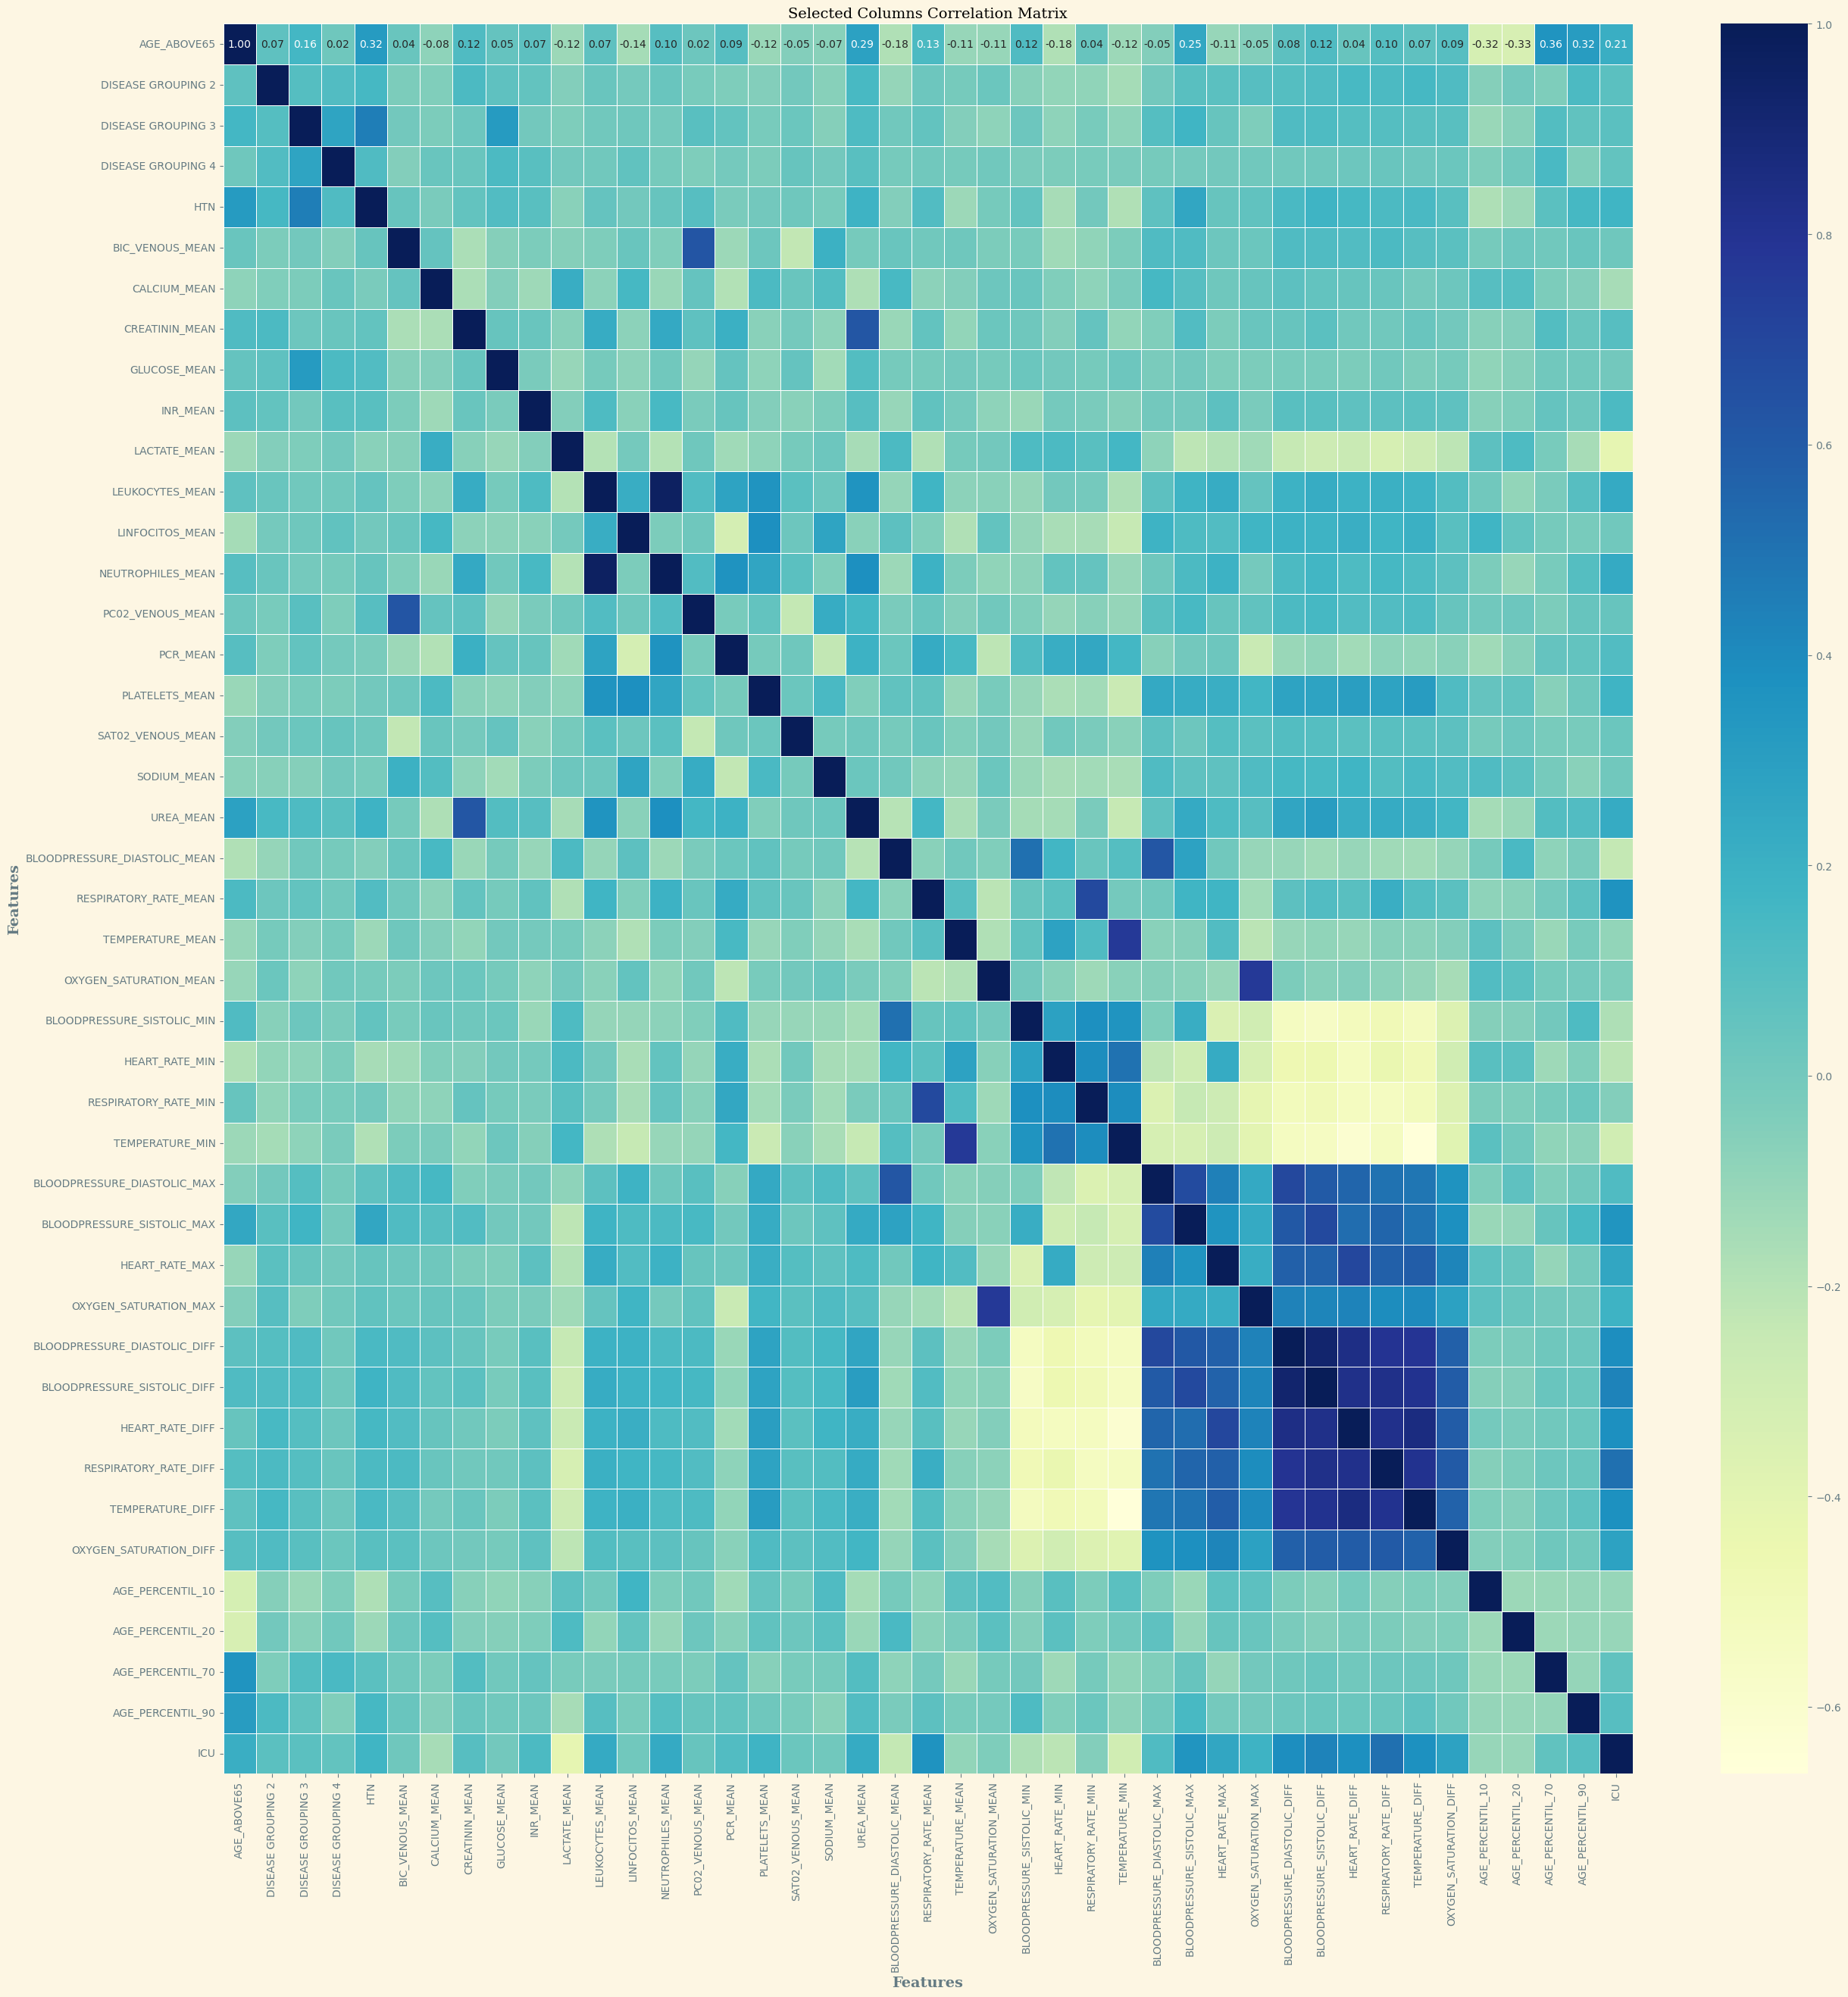

In [14]:
#Heat map with selected variables based on correlation netrix
selected_data = data_ICU_readd[['AGE_ABOVE65', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'HTN', 'BIC_VENOUS_MEAN',
                                'CALCIUM_MEAN', 'CREATININ_MEAN', 'GLUCOSE_MEAN', 'INR_MEAN', 'LACTATE_MEAN','LEUKOCYTES_MEAN', 'LINFOCITOS_MEAN',
                                'NEUTROPHILES_MEAN', 'PC02_VENOUS_MEAN', 'PCR_MEAN', 'PLATELETS_MEAN', 'SAT02_VENOUS_MEAN', 'SODIUM_MEAN',
                                'UREA_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'OXYGEN_SATURATION_MEAN',
                                'BLOODPRESSURE_SISTOLIC_MIN', 'HEART_RATE_MIN', 'RESPIRATORY_RATE_MIN', 'TEMPERATURE_MIN', 'BLOODPRESSURE_DIASTOLIC_MAX',
                                'BLOODPRESSURE_SISTOLIC_MAX', 'HEART_RATE_MAX', 'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
                                'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
                                'AGE_PERCENTIL_10', 'AGE_PERCENTIL_20', 'AGE_PERCENTIL_70', 'AGE_PERCENTIL_90', 'ICU']]

#calculate correlation matrix with selected data
selected_correlation_matrix = selected_data.corr()
#Display heatmap with selected columns based on correlation

    #Plot + Axis parameters
plt.style.use("Solarize_Light2")    #customize plot style

plt.figure(figsize=(30, 30))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.xlabel('Features', fontsize=14, fontweight='bold', family='serif')
plt.ylabel('Features', fontsize=14, fontweight='bold', family='serif')

plt.title("Selected Columns Correlation Matrix", fontsize=14, family='serif')


In [15]:
df_final = selected_data
print(tabulate(df_final.head(10), headers='keys', tablefmt='fancy_grid'))
print(df_final.columns)

╒════╤═══════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═══════╤═══════════════════╤════════════════╤══════════════════╤════════════════╤════════════╤════════════════╤═══════════════════╤═══════════════════╤═════════════════════╤════════════════════╤════════════╤══════════════════╤═════════════════════╤═══════════════╤═════════════╤════════════════════════════════╤═════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════════════╤══════════════════╤════════════════════════╤═══════════════════╤═══════════════════════════════╤══════════════════════════════╤══════════════════╤═════════════════════════╤════════════════════════════════╤═══════════════════════════════╤═══════════════════╤═════════════════════════╤════════════════════╤══════════════════════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╤═══════╕
│    │   AGE_ABOVE65 │   DISEASE GROUPING 2 │   DISEASE GROUPING 3 │ 

# Testing + Training Covid-19 Data

The models included in this study: Logistic Regression, Random Forest, Gradient Boosting,  and SGD Classifier

In [16]:
#Data Preprocessing
df_training = df_final.dropna(axis = 0)    #dropping rows containing 'nan' values

    # Select features/ target
X_data = df_training.drop('ICU', axis=1)
Y_data = ICU_column #target variable

# Drop rows with missing values in both X_data and Y_data
df_combined = pd.concat([X_data, Y_data], axis=1)
df_combined = df_combined.dropna()
X_data_clean = df_combined.drop(columns='ICU')
y_data_clean = df_combined['ICU']
print(X_data_clean.shape)
print(y_data_clean.shape)

dummies_df = pd.get_dummies(X_data, drop_first=True)
#Splitting data for training
X_train, X_test, y_train, y_test = train_test_split(X_data_clean,y_data_clean, test_size=0.30, random_state=42)


(1915, 42)
(1915,)


In [17]:
#Logistic Regression
LR_Model = LogisticRegression(random_state=42)
LR_Model.fit(X_train, y_train)
pred_LR = LR_Model.predict(X_test)
print("Logistic Regression:")
print("Accuracy", accuracy_score(y_test, pred_LR))
print("Classification Report:\n", classification_report(y_test, pred_LR))
print("Confusion Matrix:", confusion_matrix(y_test, pred_LR))

Logistic Regression:
Accuracy 0.8504347826086956
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       407
           1       0.86      0.58      0.70       168

    accuracy                           0.85       575
   macro avg       0.85      0.77      0.80       575
weighted avg       0.85      0.85      0.84       575

Confusion Matrix: [[391  16]
 [ 70  98]]


In [18]:
#Random Forest Classifier

    #Train Model
RF_Model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_Model.fit(X_train, y_train)
pred_RF = RF_Model.predict(X_test)

print("Random Forest Classifier")
print("Accuracy", accuracy_score(y_test, pred_RF))
print("Classification Report:\n", classification_report(y_test, pred_RF))
print("Confusion Matrix:", confusion_matrix(y_test, pred_RF))

Random Forest Classifier
Accuracy 0.8817391304347826
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       407
           1       0.89      0.68      0.77       168

    accuracy                           0.88       575
   macro avg       0.88      0.82      0.85       575
weighted avg       0.88      0.88      0.88       575

Confusion Matrix: [[393  14]
 [ 54 114]]


In [37]:
# Gradient Boosting Classifier
GB_Model = GradientBoostingClassifier(n_estimators=100, random_state=42)
GB_Model.fit(X_train, y_train) #train model
pred_GB = GB_Model.predict(X_test)

print("Gradient Boosting Classifier")
print("Accuracy", accuracy_score(y_test, pred_GB))
print("Classification Report:\n", classification_report(y_test, pred_GB))
print("Confusion Matrix:", confusion_matrix(y_test, pred_GB))

Gradient Boosting Classifier
Accuracy 0.8869565217391304
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       407
           1       0.89      0.70      0.78       168

    accuracy                           0.89       575
   macro avg       0.89      0.83      0.85       575
weighted avg       0.89      0.89      0.88       575

Confusion Matrix: [[392  15]
 [ 50 118]]


In [36]:
#Stochastic Gradient Decent (SGD) Classifier
SGD_Model = SGDClassifier(loss='log', max_iter=1000, random_state=42)
SGD_Model.fit(X_train, y_train)
pred_SGD = SGD_Model.predict(X_test)

print("SGD Classifier")
print("Accuracy", accuracy_score(y_test, pred_SGD))
print("Classification Report:\n", classification_report(y_test, pred_SGD))
print("Confusion Matrix:", confusion_matrix(y_test, pred_SGD))

SGD Classifier
Accuracy 0.8591304347826086
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       407
           1       0.82      0.66      0.73       168

    accuracy                           0.86       575
   macro avg       0.85      0.80      0.82       575
weighted avg       0.86      0.86      0.85       575

Confusion Matrix: [[383  24]
 [ 57 111]]


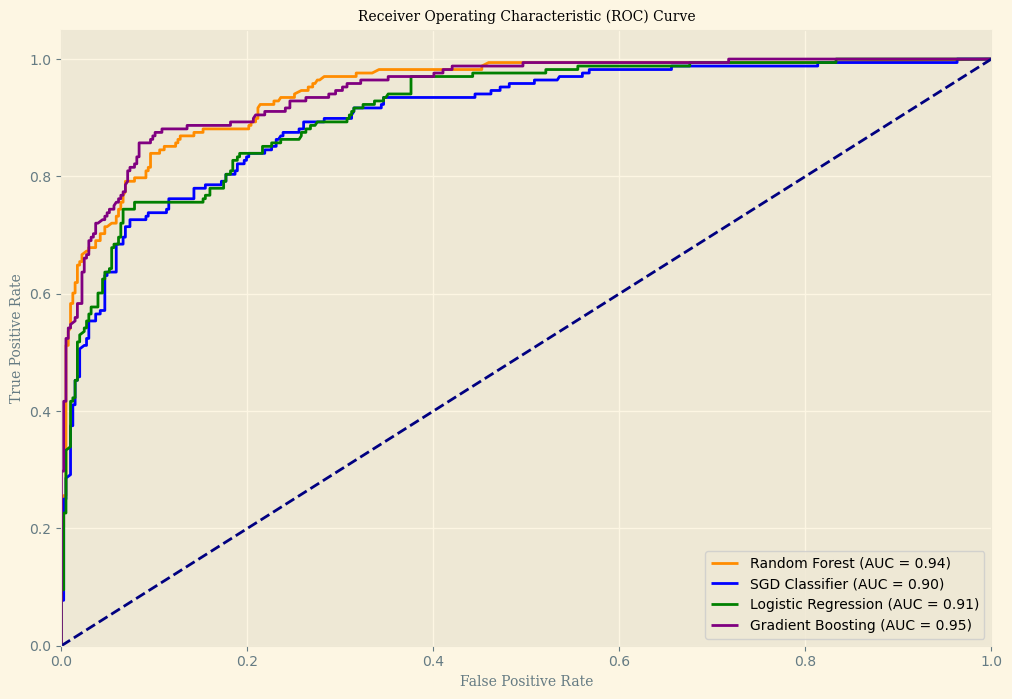

In [38]:
#Ploting ROC Curves
# Generate predicted probabilities
prob_RF = RF_Model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Random Forest Classifier)
prob_SGD = SGD_Model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (SGD Classifier)
prob_LR = LR_Model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (Logistic Regression Classiifier)
prob_GB = GB_Model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Gradient Boosting)

#Compute ROC Curves
    #Random Forest
fpr_RF, tpr_RF, _ = roc_curve(y_test, prob_RF)
roc_auc_RF = roc_auc_score(y_test, prob_RF)
    #SGD Classifier
fpr_SGD, tpr_SGD, _ = roc_curve(y_test, prob_SGD)
roc_auc_SGD = roc_auc_score(y_test, prob_SGD)
    #Logistic Regression
fpr_LR, tpr_LR, _ = roc_curve(y_test, prob_LR)
roc_auc_LR = roc_auc_score(y_test, prob_LR)
    #Gradient Boosting
fpr_GB, tpr_GB, _ = roc_curve(y_test, prob_GB)
roc_auc_GB = roc_auc_score(y_test, prob_GB)
    
    
# Plot ROC Curves
plt.figure(figsize=(12, 8))

plt.plot(fpr_RF, tpr_RF, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_RF)
plt.plot(fpr_SGD, tpr_SGD, color='blue', lw=2, label='SGD Classifier (AUC = %0.2f)' % roc_auc_SGD)
plt.plot(fpr_LR, tpr_LR, color='green', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_LR)
plt.plot(fpr_GB, tpr_GB, color='purple', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_GB)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', font='serif')
plt.ylabel('True Positive Rate', font='serif')
plt.title('Receiver Operating Characteristic (ROC) Curve', font='serif')
plt.legend(loc='lower right')
plt.grid(True)


# Visuals + Figures

Visuals based on demographic information

ICU Patient Counts:
ICU
0    1410
1     515
Name: count, dtype: int64


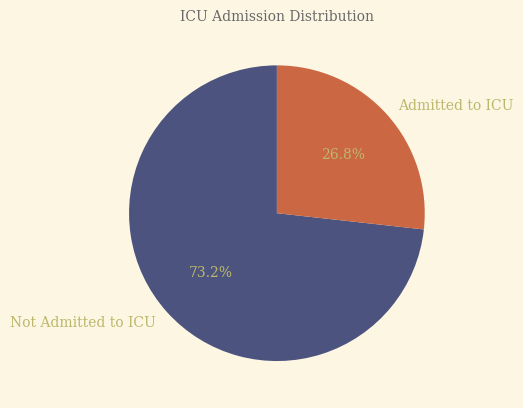

In [21]:
#Pie chart of ICU admission
df_fill_values['ICU_ADMITTED'] = df_fill_values['ICU'].fillna(0).astype(int)
icu_admission_count = df_fill_values['ICU_ADMITTED'].value_counts()

    #plot + axis parameters
plt.style.use("Solarize_Light2")    #customize plot style
plt.pie(icu_admission_count, labels=['Not Admitted to ICU', 'Admitted to ICU'], autopct='%1.1f%%',
        colors=['#4B537E', '#CC6744'], startangle=90, textprops={'color': 'darkkhaki', 'fontfamily': 'serif'})
plt.title("ICU Admission Distribution", fontsize=14, font='serif', color='dimgray')

    #Display number of patients inside/outside ICU
icu_counts = data_ICU_readd['ICU'].value_counts()
print("ICU Patient Counts:")
print(icu_counts)


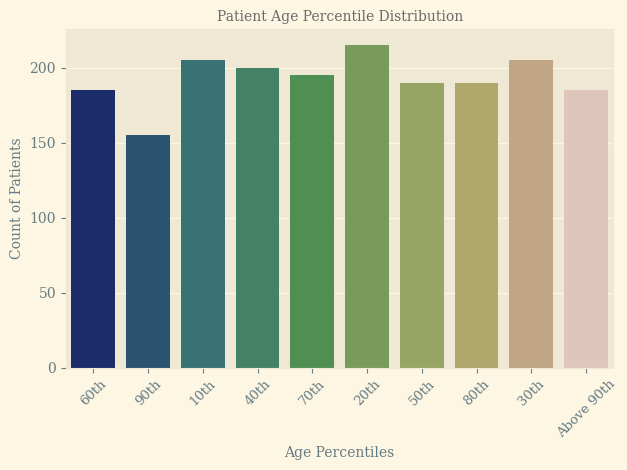

In [22]:
#Age Distribution Bar Plot

    #Plot + Axis Parameters
plt.style.use("Solarize_Light2")    #customize plot style
sns.countplot(data=df_orig, x='AGE_PERCENTIL', palette='gist_earth')
plt.title("Patient Age Percentile Distribution", fontsize=14, font='serif', color='dimgray')
plt.xlabel("Age Percentiles", font='serif')
plt.ylabel("Count of Patients", font='serif')
plt.xticks(rotation=45, font='serif', fontsize=9.5)
plt.yticks(font='serif')
plt.tight_layout()

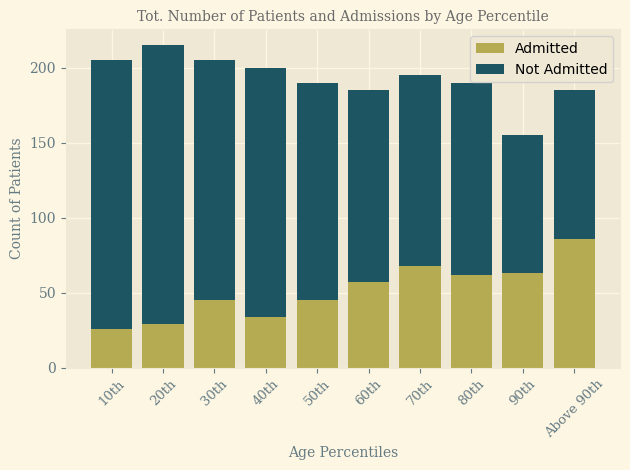

In [23]:
#Age distribution with ICU admission
df_orig['ICU_ADMITTED'] = df_orig['ICU'].fillna(0).astype(int)

#Aggregate data
age_summary = df_orig.groupby('AGE_PERCENTIL').agg(
    total_patients=('ICU_ADMITTED', 'size'),
    admitted_patients=('ICU_ADMITTED', 'sum')
).reset_index()

#Calculation for Patients not Admitted
age_summary['non_admitted_patients'] = age_summary['total_patients'] - age_summary['admitted_patients']
plt.bar(age_summary['AGE_PERCENTIL'], age_summary['admitted_patients'], color='#B5AB53', label='Admitted')
plt.bar(age_summary['AGE_PERCENTIL'], age_summary['non_admitted_patients'], color='#1E5562', bottom=age_summary['admitted_patients'], label='Not Admitted')


 #Plot + Axis Parameters
plt.style.use("Solarize_Light2")    #customize plot style
plt.title("Tot. Number of Patients and Admissions by Age Percentile",
          fontsize=14, font='serif', color='dimgray')
plt.xlabel("Age Percentiles", font='serif')
plt.ylabel("Count of Patients", font='serif')
plt.xticks(rotation=45, font='serif', fontsize=9.5)
plt.yticks(font='serif')
plt.legend()
plt.tight_layout()


In [24]:
#Datatable displaying admitted and nonadmitted patients based on age percentiles
print(tabulate(age_summary, headers='keys', tablefmt="fancy_grid"))


╒════╤═════════════════╤══════════════════╤═════════════════════╤═════════════════════════╕
│    │ AGE_PERCENTIL   │   total_patients │   admitted_patients │   non_admitted_patients │
╞════╪═════════════════╪══════════════════╪═════════════════════╪═════════════════════════╡
│  0 │ 10th            │              205 │                  26 │                     179 │
├────┼─────────────────┼──────────────────┼─────────────────────┼─────────────────────────┤
│  1 │ 20th            │              215 │                  29 │                     186 │
├────┼─────────────────┼──────────────────┼─────────────────────┼─────────────────────────┤
│  2 │ 30th            │              205 │                  45 │                     160 │
├────┼─────────────────┼──────────────────┼─────────────────────┼─────────────────────────┤
│  3 │ 40th            │              200 │                  34 │                     166 │
├────┼─────────────────┼──────────────────┼─────────────────────┼───────────────

Age Distribution
Patients below age 65:  1025
Patients above age 65:  900
Age Distribution
Patients below age 65:  184
Patients above age 65:  331


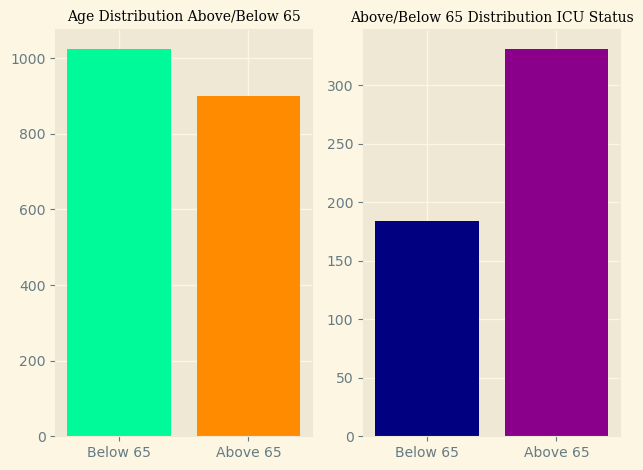

In [25]:
#Distribution of patients above/below 65 based on ICU status

    #Above/Below 65 Distribution:
Age_distribution = data_ICU_readd['AGE_ABOVE65'].value_counts()
print("Age Distribution")
print("Patients below age 65: ",Age_distribution[0])
print("Patients above age 65: ",Age_distribution[1])
labels= ['Below 65', 'Above 65']

    #Plot + axis parameters (Age Plot)
plt.subplot(1, 2, 1)
sizes= [Age_distribution[0], Age_distribution[1]]
plt.bar(labels, sizes, color=['mediumspringgreen', 'darkorange'])
plt.title("Age Distribution Above/Below 65", fontsize=10, font='serif')
plt.tight_layout()

    #Above/Below 65 Distribution based on ICU Status
plt.subplot(1, 2, 2)
ICU_Admitted_data = data_ICU_readd[data_ICU_readd['ICU']==1]
Age_distribution = ICU_Admitted_data['AGE_ABOVE65'].value_counts()
print("Age Distribution")
print("Patients below age 65: ",Age_distribution[0])
print("Patients above age 65: ",Age_distribution[1])
labels= ['Below 65', 'Above 65']
sizes= [Age_distribution[0], Age_distribution[1]]
plt.bar(labels, sizes, color=['navy', 'darkmagenta'])
plt.title("Above/Below 65 Distribution ICU Status", fontsize=10, font='serif')
plt.tight_layout()



Age appears to be a factor in ICU admission with patients in the higher age percentile group and those above 65 being granted more admission.


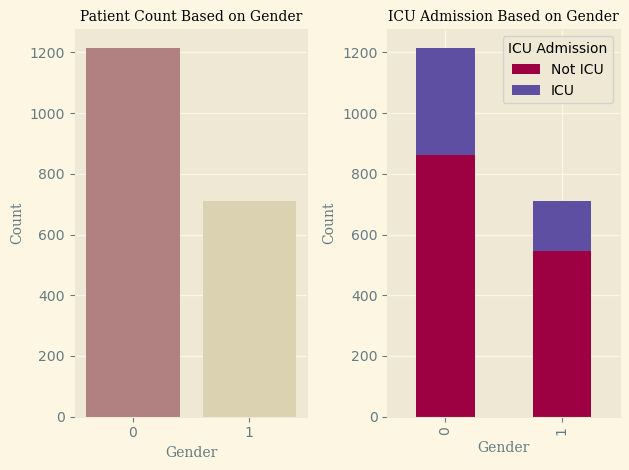

In [26]:
# Count the number of patients by gender
gender_counts = data_ICU_readd['GENDER'].value_counts()
    #plot + axis parameters
plt.subplot(1, 2, 1)
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pink')
plt.title('Patient Count Based on Gender', fontsize=10, font='serif')
plt.xlabel('Gender', font='serif')
plt.ylabel('Count', font='serif')

# Bar Chart 2: ICU Admission Based on Gender
plt.subplot(1, 2, 2)
icu_gender_counts = data_ICU_readd.groupby(['GENDER', 'ICU']).size().unstack().fillna(0)
icu_gender_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Spectral')
plt.title('ICU Admission Based on Gender', fontsize=10, font='serif')
plt.xlabel('Gender', font='serif')
plt.ylabel('Count', font='serif')
plt.legend(title='ICU Admission', labels=['Not ICU', 'ICU'])

plt.tight_layout()

The gender coding is not defined by the original data source. There does appear to be a bias for one gender over the other since the number of admissions vs nonadmission is proportional to the counts based on gender

In [28]:

#Define disease grouping columns
disease_columns = [
    'DISEASE GROUPING 1',
    'DISEASE GROUPING 2',
    'DISEASE GROUPING 3',
    'DISEASE GROUPING 4',
    'DISEASE GROUPING 5',
    'DISEASE GROUPING 6'
]
# Dictionary to store counts
disease_counts_ad = {}  #admitted
disease_counts_notad = {} #not admitted

# repeat over each disease grouping column
for column in disease_columns:
    count = data_ICU_readd[column].value_counts().get(1)
    disease_counts_ad[column] = count
for column in disease_columns:
    count = data_ICU_readd[column].value_counts().get(0)
    disease_counts_notad[column] = count
#Admittance counts for hypertension and immunocompromised
HTN_count = (df_orig['HTN'].value_counts()[0])
Immunocomp_count = (df_orig['IMMUNOCOMPROMISED'].value_counts()[0])
HTN_count_Admitted = (df_orig['HTN'].value_counts()[1])
Immunocomp_count_Admitted = (df_orig['IMMUNOCOMPROMISED'].value_counts()[1])



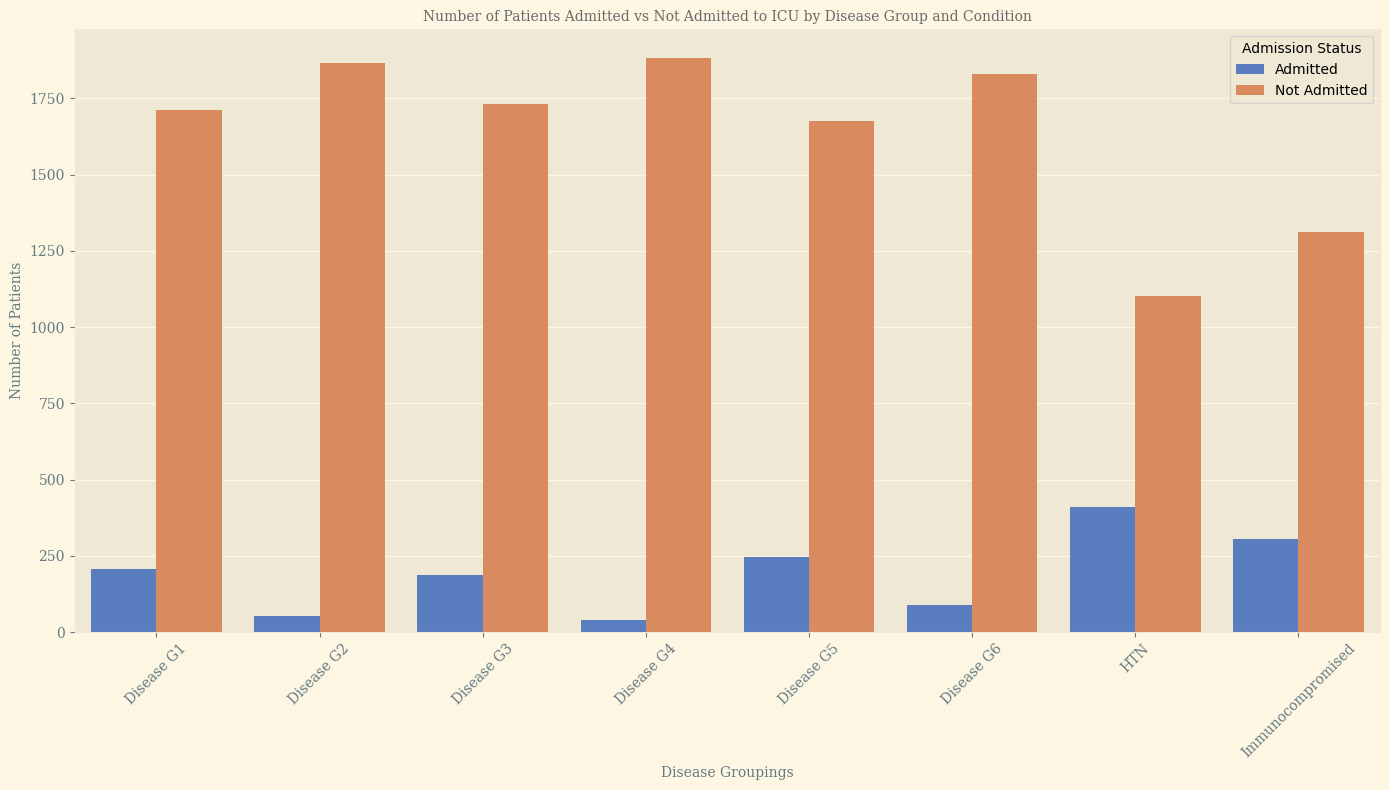

In [29]:
# Create lists for disease groupings and conditions
categories = [
    'Disease G1', 'Disease G2', 'Disease G3', 'Disease G4', 'Disease G5', 'Disease G6',
    'HTN', 'Immunocompromised'
]
# Manually preparing the counts
admitted_counts = [
    disease_counts_ad.get('DISEASE GROUPING 1', 0),
    disease_counts_ad.get('DISEASE GROUPING 2', 0),
    disease_counts_ad.get('DISEASE GROUPING 3', 0),
    disease_counts_ad.get('DISEASE GROUPING 4', 0),
    disease_counts_ad.get('DISEASE GROUPING 5', 0),
    disease_counts_ad.get('DISEASE GROUPING 6', 0),
    HTN_count_Admitted,
    Immunocomp_count_Admitted
]

not_admitted_counts = [
    disease_counts_notad.get('DISEASE GROUPING 1', 0),
    disease_counts_notad.get('DISEASE GROUPING 2', 0),
    disease_counts_notad.get('DISEASE GROUPING 3', 0),
    disease_counts_notad.get('DISEASE GROUPING 4', 0),
    disease_counts_notad.get('DISEASE GROUPING 5', 0),
    disease_counts_notad.get('DISEASE GROUPING 6', 0),
    HTN_count - HTN_count_Admitted,  # Not admitted count = total count - admitted count
    Immunocomp_count - Immunocomp_count_Admitted  # Same calculation for Immunocompromised
]

# Combine into a DataFrame
data = {
    'Category': categories * 2,  # Repeat categories for admitted and not admitted
    'Admission Status': ['Admitted'] * len(categories) + ['Not Admitted'] * len(categories),
    'Count': admitted_counts + not_admitted_counts
}

grouped_barplot_df = pd.DataFrame(data)

# Plot + Axis Parameters
plt.style.use("Solarize_Light2")    #customize plot style
plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_barplot_df, x='Category', y='Count', hue='Admission Status', errorbar=None,
    palette='muted'
)

plt.title('Number of Patients Admitted vs Not Admitted to ICU by Disease Group and Condition', fontsize = 14, font='serif', color='dimgray')
plt.xlabel('Disease Groupings', font='serif')
plt.ylabel('Number of Patients', font='serif')
plt.xticks(rotation=45, font='serif')
plt.yticks(font='serif')
plt.legend(title='Admission Status')
plt.tight_layout()


Information on how the different disease groupings were classified was not provided by the data source. Based on admission status, patients in Diease Groupings 1, 3, and 5 were more likely to receive ICU admission compared to those in Disease Groupings 2, 4, and 6.

Visuals based on vital information 

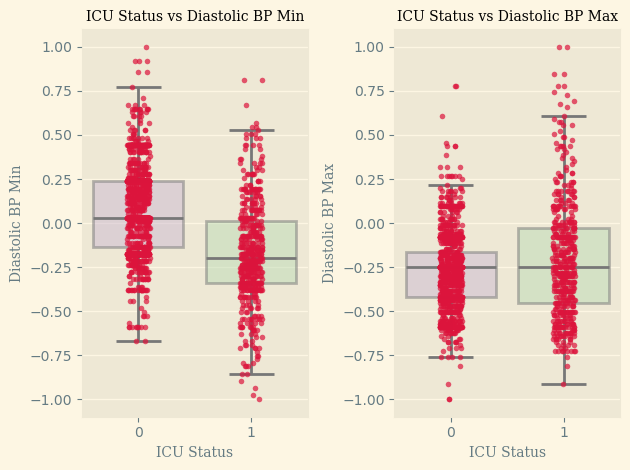

In [30]:
# Box Plot with Strip Plot 1: ICU Admission vs Diastolic Blood Pressure Min
plt.subplot(1, 2, 1)
sns.boxplot(x='ICU', y='BLOODPRESSURE_DIASTOLIC_MIN', data=data_ICU_readd, palette='PRGn', fliersize=0, boxprops=dict(alpha=0.5))
sns.stripplot(x='ICU', y='BLOODPRESSURE_DIASTOLIC_MIN', data=data_ICU_readd, color='crimson', alpha=0.7, size=4)
plt.title('ICU Status vs Diastolic BP Min', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Diastolic BP Min', font='serif')

# Box Plot with Strip Plot 2: ICU Admission vs Diastolic Blood Pressure Max
plt.subplot(1, 2, 2)
sns.boxplot(x='ICU', y='BLOODPRESSURE_DIASTOLIC_MAX', data=data_ICU_readd, palette='PRGn', fliersize=0, boxprops=dict(alpha=0.5))
sns.stripplot(x='ICU', y='BLOODPRESSURE_DIASTOLIC_MAX', data=data_ICU_readd, color='crimson', alpha=0.7, size=4)
plt.title('ICU Status vs Diastolic BP Max', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Diastolic BP Max', font='serif')

plt.tight_layout()


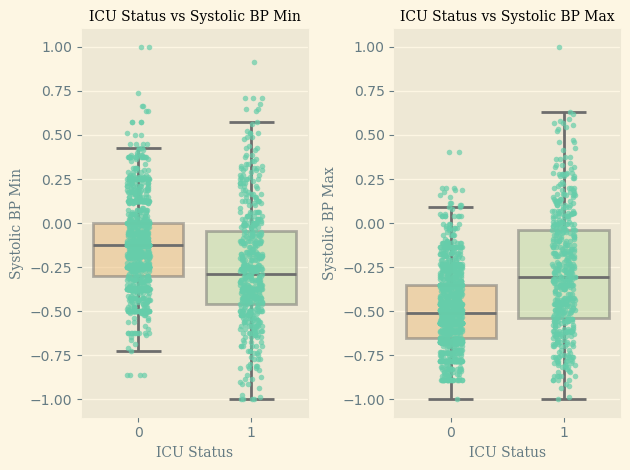

In [31]:
# Box Plot with Strip Plot 1: ICU Admission vs Systolic Blood Pressure Min
plt.subplot(1, 2, 1)
sns.boxplot(x='ICU', y='BLOODPRESSURE_SISTOLIC_MIN', data=data_ICU_readd, palette='Spectral', fliersize=0, boxprops=dict(alpha=0.5))
sns.stripplot(x='ICU', y='BLOODPRESSURE_SISTOLIC_MIN', data=data_ICU_readd, color='mediumaquamarine', alpha=0.7, size=4)
plt.title('ICU Status vs Systolic BP Min', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Systolic BP Min', font='serif')

# Box Plot with Strip Plot 2: ICU Admission vs Systolic Blood Pressure Max
plt.subplot(1, 2, 2)
sns.boxplot(x='ICU', y='BLOODPRESSURE_SISTOLIC_MAX', data=data_ICU_readd, palette='Spectral', fliersize=0, boxprops=dict(alpha=0.5))
sns.stripplot(x='ICU', y='BLOODPRESSURE_SISTOLIC_MAX', data=data_ICU_readd, color='mediumaquamarine', alpha=0.7, size=4)
plt.title('ICU Status vs Systolic BP Max', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Systolic BP Max', font='serif')
plt.tight_layout()

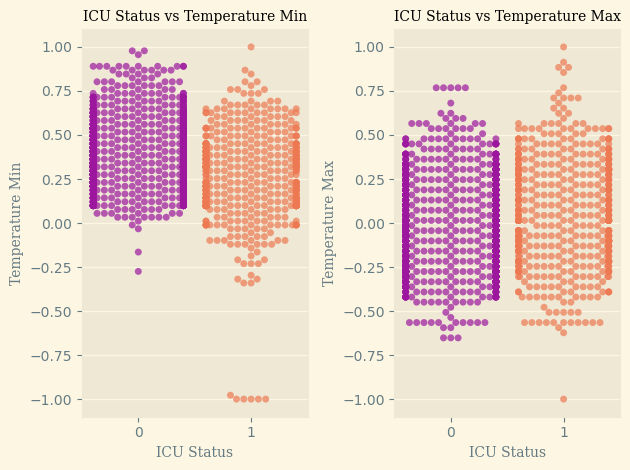

In [32]:
#Bee Swarm Plots based on Temperature (Min/Max)
# Bee Swarm Plot 1: ICU Admission vs Temperature (Min)
plt.subplot(1, 2, 1)
sns.swarmplot(x='ICU', y='TEMPERATURE_MIN', data=data_ICU_readd, palette='plasma', alpha=0.7)
plt.title('ICU Status vs Temperature Min', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Temperature Min', font='serif')

# Bee Swarm Plot 2: ICU Admission vs Temperature (Max)
plt.subplot(1, 2, 2)
sns.swarmplot(x='ICU', y='TEMPERATURE_MAX', data=data_ICU_readd, palette='plasma', alpha=0.7)
plt.title('ICU Status vs Temperature Max', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Temperature Max', font='serif')

plt.tight_layout()

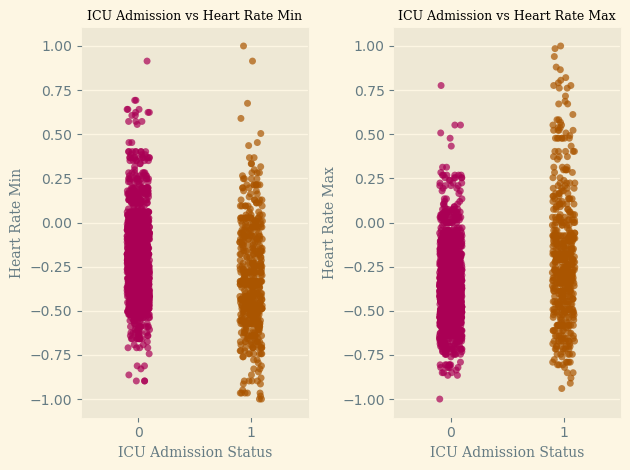

In [33]:
#Heart Rate (Min/Max) Sripplot Based on ICU Admission
plt.subplot(1, 2, 1)
sns.stripplot(x='ICU', y='HEART_RATE_MIN', data=data_ICU_readd, jitter=True, palette='brg', alpha=0.7)
plt.title('ICU Admission vs Heart Rate Min', font='serif', fontsize=9)
plt.xlabel('ICU Admission Status', font='serif')
plt.ylabel('Heart Rate Min', font='serif')

# Scatter Plot 2: ICU Admission vs Heart Rate Max
plt.subplot(1, 2, 2)
sns.stripplot(x='ICU', y='HEART_RATE_MAX', data=data_ICU_readd, jitter=True, palette='brg', alpha=0.7)

plt.title('ICU Admission vs Heart Rate Max', font='serif', fontsize=9)
plt.xlabel('ICU Admission Status', font='serif')
plt.ylabel('Heart Rate Max', font='serif')

plt.tight_layout()

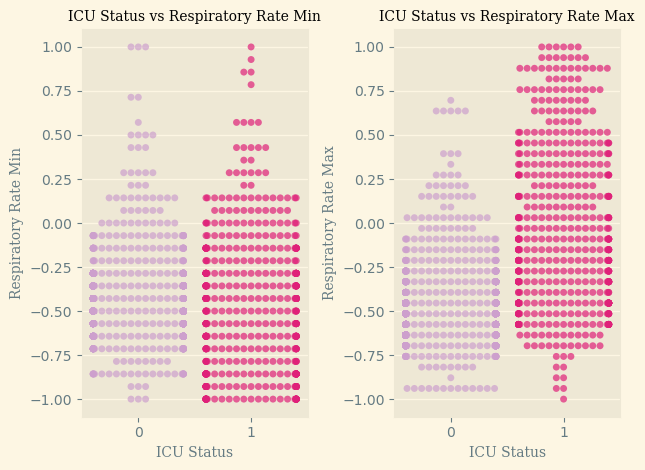

In [34]:
#Bee Swarm Plots based on Respiratory Rate (Min/Max)
# Bee Swarm Plot 1: ICU Admission vs Respiratory Rate Min
plt.subplot(1, 2, 1)
sns.swarmplot(x='ICU', y='RESPIRATORY_RATE_MIN', data=data_ICU_readd, palette='PuRd', alpha=0.7)
plt.title('ICU Status vs Respiratory Rate Min', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Respiratory Rate Min', font='serif')

# Bee Swarm Plot 2: ICU Admission vs Respiratory Rate Max
plt.subplot(1, 2, 2)
sns.swarmplot(x='ICU', y='RESPIRATORY_RATE_MAX', data=data_ICU_readd, palette='PuRd', alpha=0.7)
plt.title('ICU Status vs Respiratory Rate Max', fontsize=8, font='serif')
plt.xlabel('ICU Status', font='serif')
plt.ylabel('Respiratory Rate Max', font='serif')

plt.tight_layout()

# Conclusion

Conclusion:
From modeling the different classifiers, the Gradient Boosting Classifier performed the best with an accuracy score of 89%

For future studies I would wanted to have a better understanding of the data provided (coding for gender not explained) and use data from other hospitals in different parts of Brazil